508.8


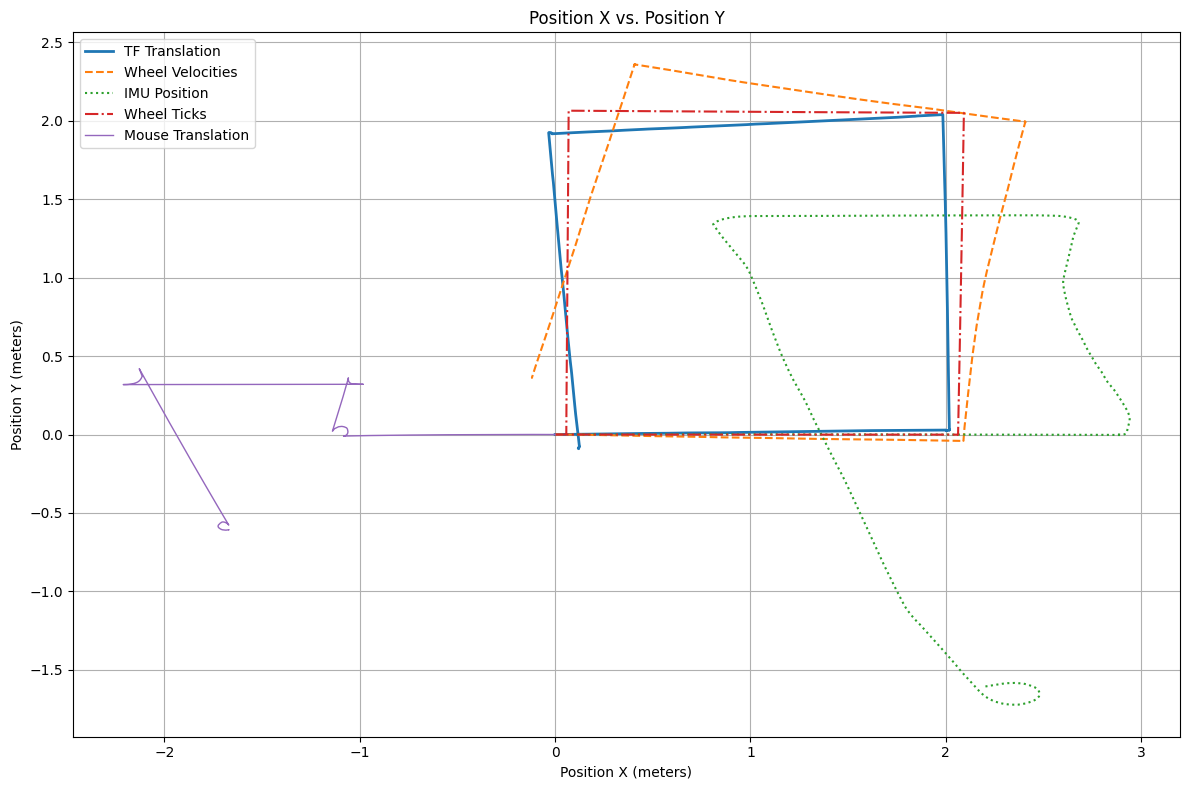

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Constants
WHEEL_RADIUS = 0.072 / 2  # Radius of the wheel (meters)
WHEEL_BASE = 0.235        # Distance between wheels (meters)
TICKS_PER_REVOLUTION = 508.8
DATA_LIMIT = 953          # Set to -1 for no limit on data

# Load data
def load_data(filename, limit=DATA_LIMIT):
    """Loads a CSV file and applies a data limit if specified."""
    df = pd.read_csv(filename)
    return df[:limit] if limit > 0 else df

# Preprocessing Functions
def add_timestamps(df, sec_col, nsec_col):
    """Add a combined timestamp column and delta_time to the dataframe."""
    df['timestamp'] = pd.to_datetime(df[sec_col], unit='s') + pd.to_timedelta(df[nsec_col], unit='ns')
    df['delta_time'] = df['timestamp'].diff().dt.total_seconds()
    return df

def calculate_wheel_velocities(df):
    """Calculate linear and angular velocities from wheel data."""
    df['linear_velocity'] = (df['velocity_left'] + df['velocity_right']) * WHEEL_RADIUS / 2
    df['angular_velocity'] = (df['velocity_right'] - df['velocity_left']) * WHEEL_RADIUS / WHEEL_BASE
    df['delta_yaw'] = df['angular_velocity'] * df['delta_time']
    df['yaw'] = df['delta_yaw'].cumsum()
    df['displacement_x'] = df['linear_velocity'] * np.cos(df['yaw']) * df['delta_time']
    df['displacement_y'] = df['linear_velocity'] * np.sin(df['yaw']) * df['delta_time']
    df['position_x'] = df['displacement_x'].cumsum()
    df['position_y'] = df['displacement_y'].cumsum()
    return df

def calculate_wheel_ticks(df):
    """Calculate velocities and positions using wheel tick data."""
    print(TICKS_PER_REVOLUTION)
    df['delta_ticks_left'] = df['ticks_left'].diff()
    df['delta_ticks_right'] = df['ticks_right'].diff()
    df['angular_velocity_left'] = (2 * np.pi * df['delta_ticks_left']) / (TICKS_PER_REVOLUTION * df['delta_time'])
    df['angular_velocity_right'] = (2 * np.pi * df['delta_ticks_right']) / (TICKS_PER_REVOLUTION * df['delta_time'])
    df['velocity_left'] = df['angular_velocity_left']
    df['velocity_right'] = df['angular_velocity_right']
    return calculate_wheel_velocities(df)

def calculate_imu_position(df):
    """Calculate positions from IMU data."""
    df['yaw'] = np.deg2rad(df['orientation_z'] * 360)
    df['speed_x'] = (df['linear_acceleration_x'] * df['delta_time']).cumsum()
    df['speed_y'] = (df['linear_acceleration_y'] * df['delta_time']).cumsum()
    df['position_x'] = (df['speed_x'] * np.cos(df['yaw']) * df['delta_time']).cumsum()
    df['position_y'] = (df['speed_y'] * np.sin(df['yaw']) * df['delta_time']).cumsum()
    return df

def calculate_mouse_position(mouse_df, imu_df):
    """Calculate mouse-based positions, rotated using IMU yaw."""
    mouse_df['delta_x'] = mouse_df['integrated_x'].diff()
    mouse_df['delta_y'] = mouse_df['integrated_y'].diff()
    mouse_df['rotated_delta_x'] = mouse_df['delta_x'] * np.cos(imu_df['yaw'])
    mouse_df['rotated_delta_y'] = mouse_df['delta_x'] * np.sin(imu_df['yaw'])
    mouse_df['position_x'] = mouse_df['rotated_delta_x'].cumsum()
    mouse_df['position_y'] = mouse_df['rotated_delta_y'].cumsum()
    return mouse_df

# Load DataFrames
tf_df = load_data('tf_data.csv')
imu_df = load_data('imu_data.csv')
mouse_df = load_data('mouse_data.csv')
wheel_ticks_df = load_data('wheel_ticks_data.csv')
wheel_vels_df = load_data('wheel_vels_data.csv')

# Process Data
imu_df = add_timestamps(imu_df, 'timestamp_sec', 'timestamp_nanosec')
imu_df = calculate_imu_position(imu_df)

mouse_df = calculate_mouse_position(mouse_df, imu_df)

wheel_ticks_df = add_timestamps(wheel_ticks_df, 'timestamp_sec', 'timestamp_nanosec')
wheel_ticks_df = calculate_wheel_ticks(wheel_ticks_df)

wheel_vels_df = add_timestamps(wheel_vels_df, 'timestamp_sec', 'timestamp_nanosec')
wheel_vels_df = calculate_wheel_velocities(wheel_vels_df)

# Plot Results
plt.figure(figsize=(12, 8))
plt.plot(tf_df['translation_x'], tf_df['translation_y'], label='TF Translation', linewidth=2)
plt.plot(wheel_vels_df['position_x'], wheel_vels_df['position_y'], label='Wheel Velocities', linestyle='--')
plt.plot(imu_df['position_x'], imu_df['position_y'], label='IMU Position', linestyle=':')
plt.plot(wheel_ticks_df['position_x'], wheel_ticks_df['position_y'], label='Wheel Ticks', linestyle='-.')
plt.plot(mouse_df['position_x'], mouse_df['position_y'], label='Mouse Translation', linewidth=1)
plt.xlabel('Position X (meters)')
plt.ylabel('Position Y (meters)')
plt.title('Position X vs. Position Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
